We'll write a simplifier a la Luckasz

In [59]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

class Solver:
    def __init__(self, n_qubits=3, qlr=0.01, qepochs=100,verbose=0, g=1, J=0):

        """"solver with n**2 possible actions: n(n-1) CNOTS + n 1-qubit unitary"""
        self.n_qubits = n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.lower_bound_Eg = -2*self.n_qubits
        
        self.qlr = qlr
        self.qepochs=qepochs
        self.verbose=verbose


        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        
        self.final_params = []
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        
        self.observable=self.ising_obs(g=g, J=J)
        self.resolver = {}
        self.new_resolver = {} #this temporarly stores initialized parameters of identity resolution
        self.lowest_energy_found = -.1
        self.best_circuit_found = []
        self.best_resolver_found = {}
        
        
    def ising_obs(self, g=1, J=0):
        # -  \Gamma/2 \sum_i Z_i - J/2 \sum_{i} X_i X_{i+1}    (S_i = \Sigma_i/2; ej S_z = Z/2, S_x = X/2)
        ### analytic solution https://sci-hub.tw/https://www.sciencedirect.com/science/article/abs/pii/0003491670902708?via%3Dihub
        observable = [-float(0.5*g)*cirq.Z.on(q) for q in self.qubits] 
        for q in range(len(self.qubits)):
            observable.append(-float(0.5*J)*cirq.X.on(self.qubits[q])*cirq.X.on(self.qubits[(q+1)%len(self.qubits)]))
        #### E_0 = -\Gamma/2 \sum_k \Lambda_k , with \Lambda_k = \sqrt{ 1 + \lambda^{2}  + 2 \lambda \cos(k)}; 
        ### k = -N/2, ... , 0 ,... N/2-1 if N even
        #### k = -(N-1)/2, ... 0 , ... (N-1)/2 if N odd
        if self.n_qubits%2 == 0:
            val = -self.n_qubits/2
        else:
            val = -(self.n_qubits-1)/2
        values_q = []
        for k in range(2*self.n_qubits-1):
            values_q.append(val)
            val += 1/2
        
        self.ground_energy = -(0.5*g)*np.sum(np.sqrt([1+(J/(2*g))**2 + (np.cos(2*np.pi*q/self.n_qubits)*(J/g)) for q in values_q]))
        return self.ground_energy

In [62]:
sol = Solver(n_qubits= 3, qlr=0.1, qepochs=100, g=1, J=1)
sol.ground_energy

-2.938901059316734

0

In [11]:
sol = Solver(n_qubits= 2, qlr=0.1, qepochs=100, g=1, J=.5)
history_energies=[]
best_energies_found = []

gates_index = [sol.number_of_cnots] ## begin with a certain circuit
gates_index, resolver, energy= sol.run_circuit_from_index(gates_index)
sol.current_circuit = gates_index

for k in range(25):
    
    which_block = np.random.choice([0,1], p=[.8,.2])
    if which_block == 0:
        qubit = np.random.choice(sol.n_qubits)
        block_to_insert = sol.resolution_1qubit(qubit)
    else:
        qubits = np.random.choice(sol.n_qubits, 2,replace = False)
        block_to_insert = sol.resolution_2cnots(qubits[0], qubits[1])
    insertion_index = np.random.choice(max(1,len(gates_index))) #gives index between \in [0, len(gates_index) )
    
    ### optimize the circuit with the block appended. This is tricky since we initialize
    ###  the continuous parameters with the older ones, and the "block ones" close to identity
    circuit, variables = sol.prepare_circuit_insertion(gates_index, block_to_insert, insertion_index)
    model = sol.initialize_model_insertion(variables) ### initialize the model in the previously optimized parameters & resolution to identity for the block
    
    gates_index, resolver, energy = sol.optimize_and_update(model, circuit, variables, insertion_index) #inside, if better circuit is found, saves it.
    s=0
    for k in range(50):
        gates_index, resolver, energy, simplified =  sol.kill_one_unitary(gates_index, resolver, energy)
        if simplified is False:
            s+=-1
        else:
            s+=1
        if s<-15:
            break

    ### now I simplify the circuit and if the length is changed I run the optimization again
    simplified_gates_index = sol.simplify_circuit(gates_index)
    if len(simplified_gates_index)<len(gates_index):
        gates_index, resolver, energy = sol.run_circuit_from_index(simplified_gates_index)
        sol.current_circuit = gates_index
        sol.resolver = resolver

    sol.new_resolver = {}
    history_energies.append(energy)
    best_energies_found.append(sol.lowest_energy_found)
    
    print("energy: ", energy)

energy:  -0.1
energy:  -0.1
energy:  -0.1
energy:  -2.222256
energy:  -2.230218
energy:  -2.2297394
energy:  -2.230114
energy:  -2.2297835
energy:  -2.2306125
energy:  -2.2309031
energy:  -2.230927
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742
energy:  -2.2307742


In [16]:
sol.ground_energy

-1.8133759499971027

In [13]:
np.sqrt(1+(1/16))*2

2.0615528128088303

Text(0.5, 0, 'iteration')

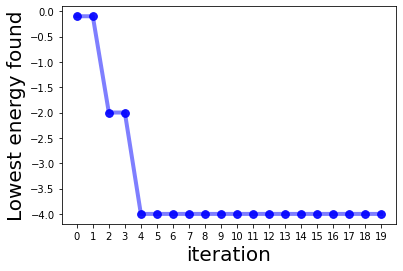

In [59]:
plt.plot(range(len(history_energies)), history_energies, linewidth=4, alpha=.5, color= "blue")
plt.scatter(range(len(history_energies)), history_energies,  s=60,alpha=.9, color= "blue", label="4 qubits")
plt.ylabel("Lowest energy found", size=20)
plt.xticks(range(len(history_energies)))
plt.xlabel("iteration", size=20)

In [72]:
hist5 = history_energies

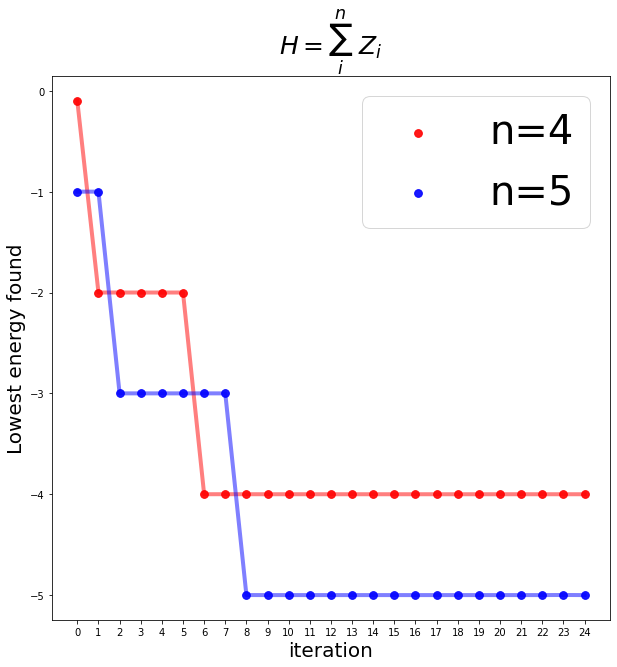

In [87]:
plt.figure(figsize=(10,10))
plt.title(r'$H = \sum_i^{n} \; Z_i$', size=25)

plt.plot(range(len(history_energies)), history_energies, linewidth=4, alpha=.5, color= "red")
plt.scatter(range(len(history_energies)), history_energies,  s=60,alpha=.9, color= "red", label="n=4")
plt.plot(range(len(hist5)), hist5, linewidth=4, alpha=.5, color= "blue")
plt.scatter(range(len(history_energies)), hist5,  s=60,alpha=.9, color= "blue", label="n=5")
plt.ylabel("Lowest energy found", size=20)
plt.xticks(range(len(history_energies)))
plt.xlabel("iteration", size=20)
plt.legend(prop={"size":40})
plt.savefig("preliminar_diagonal_ising.png")

<Figure size 432x288 with 0 Axes>

In [85]:
sol.give_circuit(sol.best_circuit_found)[0]

┌──┐                                               ┌──┐                                       ┌──┐
(0, 0): ───Rz(th_0)────Rx(th_1)────Rz(th_2)────X───Rz(th_12)───Rx(th_13)───Rz(th_14)────────────────────────────@─────Rz(th_18)───Rx(th_19)───Rz(th_20)───@────────X─────Rz(th_24)───Rx(th_25)───Rz(th_26)────X─────Rz(th_33)───Rx(th_34)───Rz(th_35)───
                                               │                                                                │                                         │        │                                          │
(0, 1): ───Rz(th_15)───Rx(th_16)───Rz(th_17)───┼────────────────────────────────────────────────────────────────┼X────────────────────────────────────────┼────────┼X────Rz(th_30)───Rx(th_31)───Rz(th_32)────┼X────────────────────────────────────────
                                               │                                                                ││                                        │        ││                                         ││
(0, 2): ───Rz(th_3)────Rx(th_4)────Rz(th_5)────┼───@───────────X───────────Rz(th_9)────Rx(th_10)───Rz(th_11)────┼@────────────────────────────────────────┼───X────@┼────Rz(th_21)───Rx(th_22)───Rz(th_23)────@┼────────────────────────────────────────
                                               │   │           │                                                │                                         │   │     │                                          │
(0, 3): ───────────────────────────────────────@───X───────────@───────────Rz(th_6)────Rx(th_7)────Rz(th_8)─────X─────────────────────────────────────────X───@─────@────Rz(th_27)───Rx(th_28)───Rz(th_29)─────@────────────────────────────────────────
                                                                                                               └──┘                                               └──┘                                       └──┘